In [2]:
dave

In [3]:
data_dir = 'data/2D/'
files = glob.glob(data_dir+'*_slices.dat')
dataframes = []

for fname in files:
    print(fname)
    df = read_2d_slice_data(fname)
    # Shift leading edge to (0,0)
    df['CoordinateX'] = df['CoordinateX'] - df['CoordinateX'].values[0]
    df['CoordinateY'] = df['CoordinateY'] - df['CoordinateY'].values[0]
    dataframes.append(df)

data/2D/fc_027_slices.dat
data/2D/fc_010_slices.dat
data/2D/fc_045_slices.dat
data/2D/fc_059_slices.dat
data/2D/fc_048_slices.dat
data/2D/fc_063_slices.dat
data/2D/fc_054_slices.dat
data/2D/fc_001_slices.dat
data/2D/fc_036_slices.dat
data/2D/fc_018_slices.dat
data/2D/fc_051_slices.dat
data/2D/fc_066_slices.dat
data/2D/fc_033_slices.dat
data/2D/fc_004_slices.dat
data/2D/fc_015_slices.dat
data/2D/fc_022_slices.dat
data/2D/fc_040_slices.dat
data/2D/fc_009_slices.dat
data/2D/fc_039_slices.dat
data/2D/fc_012_slices.dat
data/2D/fc_025_slices.dat
data/2D/fc_070_slices.dat
data/2D/fc_047_slices.dat
data/2D/fc_056_slices.dat
data/2D/fc_061_slices.dat
data/2D/fc_034_slices.dat
data/2D/fc_003_slices.dat
data/2D/fc_028_slices.dat
data/2D/fc_064_slices.dat
data/2D/fc_053_slices.dat
data/2D/fc_006_slices.dat
data/2D/fc_031_slices.dat
data/2D/fc_069_slices.dat
data/2D/fc_020_slices.dat
data/2D/fc_017_slices.dat
data/2D/fc_042_slices.dat
data/2D/fc_019_slices.dat
data/2D/fc_050_slices.dat
data/2D/fc_0

In [3]:
dataframes[0]

,CoordinateX,CoordinateY,CoordinateZ,VX,VY,VZ,CP,NodeC1,NodeC2
96,0.000000,0.000000,0.5,-0.004797,0.015346,2.070778e-14,1.053297,101.0,102.0
97,0.000320,-0.000478,0.5,0.000728,0.001213,1.660772e-14,1.095045,102.0,103.0
98,0.001118,-0.001027,0.5,0.008122,-0.004027,1.020438e-14,0.911812,103.0,104.0
99,0.002485,-0.001572,0.5,0.011837,-0.003920,4.086589e-15,0.735352,104.0,105.0
100,0.004414,-0.002088,0.5,0.012820,-0.003006,2.485264e-16,0.642421,105.0,106.0
...,...,...,...,...,...,...,...,...,...
186,0.000242,0.001439,0.5,0.014262,0.025301,1.229727e-14,0.513479,NaN,NaN
187,-0.000010,0.000869,0.5,0.008840,0.027507,1.683396e-14,0.702799,NaN,NaN
188,-0.000074,0.000534,0.5,0.003133,0.025908,1.958015e-14,0.757351,NaN,NaN
189,-0.000079,0.000425,0.5,-0.000640,0.028576,2.091732e-14,0.707742,NaN,NaN


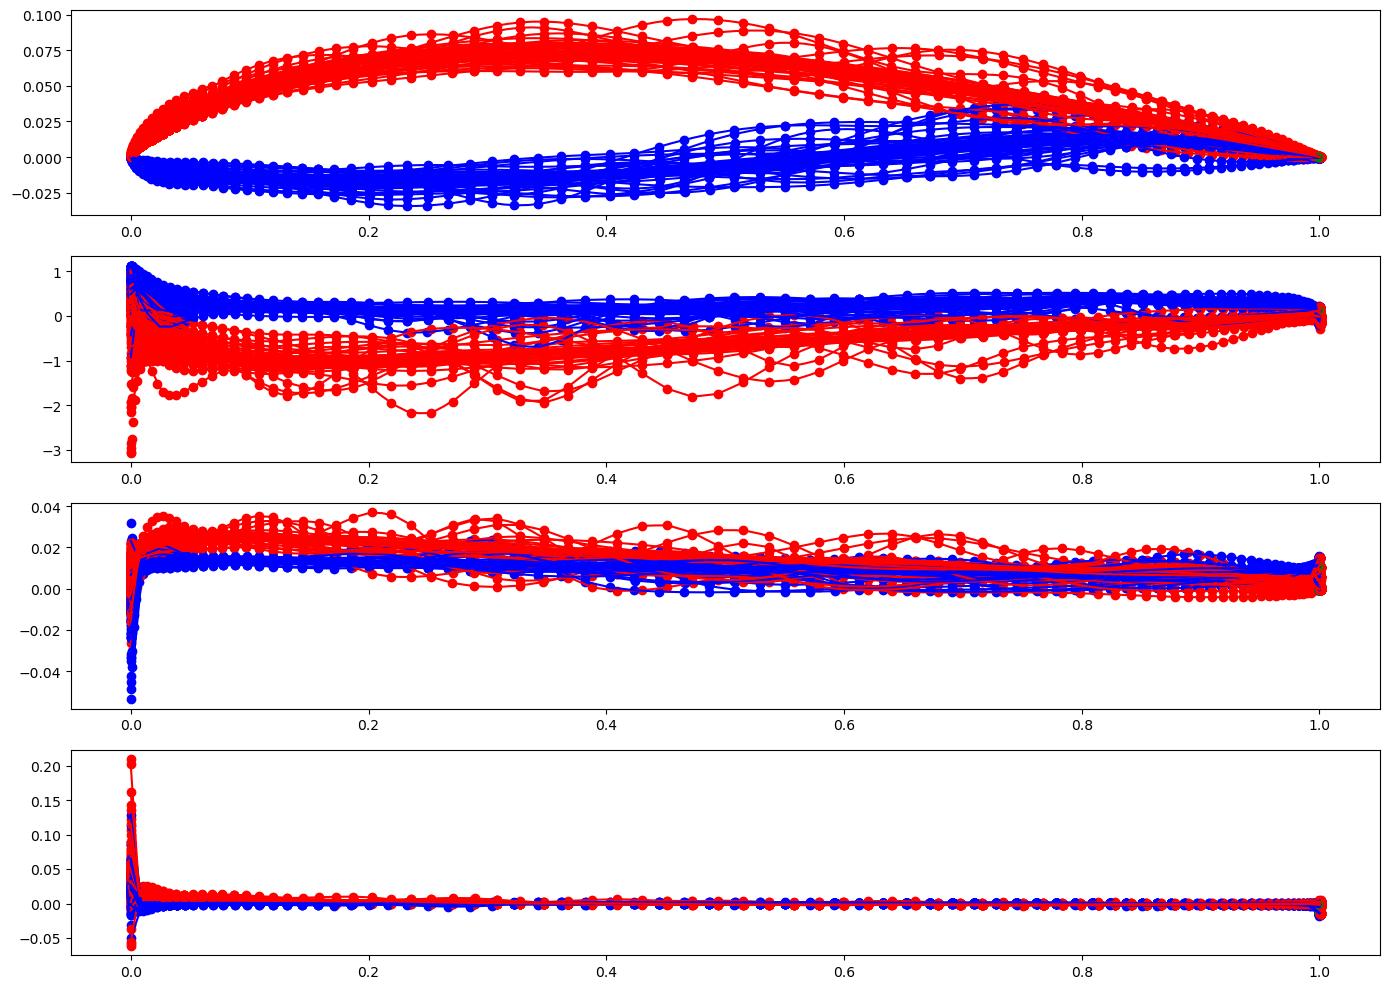

In [14]:
ns = 100
ndim = 2
nvar = 3
ndata = len(dataframes)
fig, axs = plt.subplots(nrows=1+nvar, ncols=1, figsize=(14,10), tight_layout=True)

geom_array = np.zeros((ndata, 2, ns, ndim))
field_array = np.zeros((ndata, 2, ns, nvar))

for i, df in enumerate(dataframes):
    # Fit raw spatial data to B-Splines
    x, y, cp, vx, vy = df['CoordinateX'].values, df['CoordinateY'].values, df['CP'].values, df['VX'].values, df['VY'].values
    vars = np.concatenate((cp.reshape(-1,1), vx.reshape(-1,1), vy.reshape(-1,1)), axis=1)
    xspline, yspline, s, xtip, ytip, idx_tip = fit_raw_Bspline(x, y)
    
    # Rotate and scale raw data
    x, y, xtip, ytip = rotate_scale(x, y, xtip, ytip)
    
    # Separate data (geometric and fluid) intp top and bottom components
    xyb, xyt, vb, vt, idx_tip = separate_top_bottom(x, y, vars, idx_tip)
    xb, yb, xt, yt = xyb[:,0], xyb[:,1], xyt[:,0], xyt[:,1]
        
    # Fit B-Spline to bottom processed coordinate/field data
    xysb, vsb, sb = spline_field_fit(xyb, vb, ns)
    
    # Fit B-Spline to top processed coordinate/field data
    xyst, vst, st = spline_field_fit(xyt, vt, ns)

    # Decompose x/y coordinates
    xsb, ysb, xst, yst = xysb[:,0], xysb[:,1], xyst[:,0], xyst[:,1]

    # Store geometry and field data
    geom_array[i,0,:,:], geom_array[i,1,:,:] =  xysb, xyst
    field_array[i,0,:,:], field_array[i,1,:,:] = vsb, vst
    
    # Geometry
    axs[0].scatter(xb, yb, c='b')
    axs[0].plot(xsb, ysb, c='b')
    axs[0].scatter(xt, yt, c='r')
    axs[0].plot(xst, yst, c='r')
    axs[0].scatter(xb[idx_tip], yb[idx_tip], c='g')
    
    # Field
    for i in range(nvar):
        axs[1+i].scatter(xb, vb[:,i], c='b')
        axs[1+i].plot(xsb, vsb[:,i], c='b')
        axs[1+i].scatter(xt, vt[:,i], c='r')
        axs[1+i].plot(xst, vst[:,i], c='r')
        axs[1+i].scatter(xb[idx_tip], vb[idx_tip,i], c='g')

1.2878678427352435


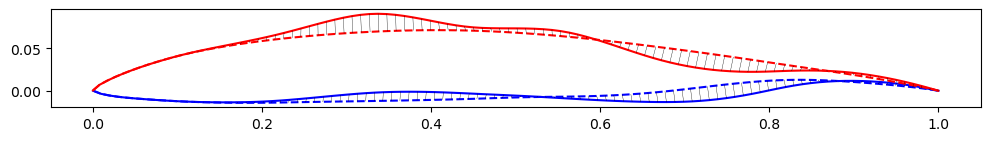

In [37]:
# Create geometric distances

i1 = 7
i2 = 47

fig, ax = plt.subplots(figsize=(12,6))

db = np.sum(np.sqrt(np.sum((geom_array[i1,0,:,:] - geom_array[i2,0,:,:])**2, axis=1)))
dt = np.sum(np.sqrt(np.sum((geom_array[i1,1,:,:] - geom_array[i2,1,:,:])**2, axis=1)))
d = db+dt
print(d)

ax.plot(geom_array[i1,0,:,0], geom_array[i1,0,:,1], 'b')
ax.plot(geom_array[i2,0,:,0], geom_array[i2,0,:,1], linestyle='--', c='b')

ax.plot(geom_array[i1,1,:,0], geom_array[i1,1,:,1], 'r')
ax.plot(geom_array[i2,1,:,0], geom_array[i2,1,:,1], linestyle='--', c='r')

for i in range(ns):
    ax.plot([geom_array[i1,0,i,0], geom_array[i2,0,i,0]], [geom_array[i1,0,i,1], geom_array[i2,0,i,1]], c='k', linewidth=.25)
    ax.plot([geom_array[i1,1,i,0], geom_array[i2,1,i,0]], [geom_array[i1,1,i,1], geom_array[i2,1,i,1]], c='k', linewidth=.25)

ax.set_aspect('equal')
plt.show()

In [41]:
distance_geometry = np.ones((ndata, ndata))*1e6

for i1 in range(ndata-1):
    for i2 in range(i1+1,ndata):
        db = np.sum(np.sqrt(np.sum((geom_array[i1,0,:,:] - geom_array[i2,0,:,:])**2, axis=1)))
        dt = np.sum(np.sqrt(np.sum((geom_array[i1,1,:,:] - geom_array[i2,1,:,:])**2, axis=1)))
        distance_geometry[i1, i2] = db + dt


distance_field = np.ones((ndata, ndata, nvar))*1e6

for i1 in range(ndata-1):
    for i2 in range(i1+1,ndata):
        for ivar in range(nvar):
            db = np.sum(np.sqrt(np.sum((field_array[i1,0,:,ivar] - field_array[i2,0,:,ivar])**2)))
            dt = np.sum(np.sqrt(np.sum((field_array[i1,1,:,ivar] - field_array[i2,1,:,ivar])**2)))
            distance_field[i1, i2, ivar] = db + dt

In [94]:
# Get the indices that would sort the flattened array
arr = distance_geometry
flat_indices = np.argsort(arr.ravel())

# Convert the flat indices to 2D indices
sorted_indices = np.unravel_index(flat_indices, arr.shape)

# Combine the indices into a list of tuples
results = list(zip(*sorted_indices))

for i, result in enumerate(results):
    if (arr[result]<1e-1) or (arr[result]>1e4):
        distance_geometry[result] = 1e6
        distance_field[result[0], result[1], :] = 1e6
    else:
        print(result, arr[result])

(2, 61) 0.1053005849114364
(51, 55) 0.10621024844994371
(2, 43) 0.11409953865053371
(6, 51) 0.11583912709278263
(4, 61) 0.1169565336810563
(37, 51) 0.11953203485304928
(37, 61) 0.11961285609746655
(25, 39) 0.12131730420180259
(2, 51) 0.12497268890794794
(37, 43) 0.12956187815538134
(4, 43) 0.1306720086752176
(4, 51) 0.13394590460478484
(25, 61) 0.14007489159002887
(22, 61) 0.14392527023188173
(43, 55) 0.14611296654948835
(55, 61) 0.14855228731275966
(25, 57) 0.149177011230606
(22, 51) 0.1546643826423063
(18, 43) 0.15578917487924804
(22, 43) 0.15715111362563705
(48, 61) 0.1576242041290521
(32, 61) 0.1576901336274246
(61, 68) 0.1576901336274246
(21, 61) 0.1576901336274246
(61, 65) 0.1576901336274246
(58, 61) 0.1576901336274246
(38, 61) 0.1576901351329223
(11, 61) 0.15769013513300228
(54, 61) 0.15769013786167468
(28, 61) 0.15769024627073905
(5, 61) 0.1576915251042793
(50, 61) 0.15770379694532316
(61, 67) 0.1578245847323111
(24, 61) 0.15782773023435404
(3, 61) 0.15806029031119717
(43, 48) 

3.683517479041324


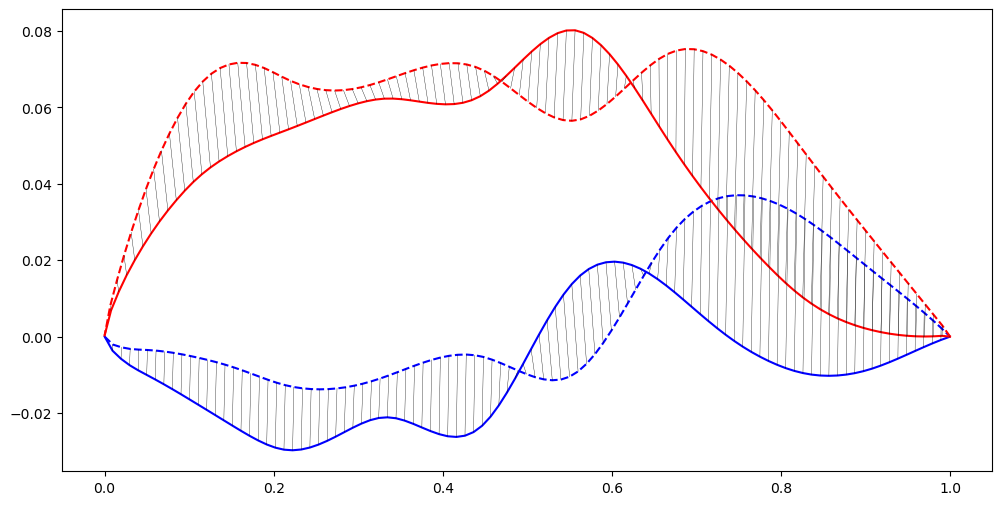

In [90]:
# Create geometric distances

i1 = 17
i2 = 40

fig, ax = plt.subplots(figsize=(12,6))

db = np.sum(np.sqrt(np.sum((geom_array[i1,0,:,:] - geom_array[i2,0,:,:])**2, axis=1)))
dt = np.sum(np.sqrt(np.sum((geom_array[i1,1,:,:] - geom_array[i2,1,:,:])**2, axis=1)))
d = db+dt
print(d)

ax.plot(geom_array[i1,0,:,0], geom_array[i1,0,:,1], 'b')
ax.plot(geom_array[i2,0,:,0], geom_array[i2,0,:,1], linestyle='--', c='b')

ax.plot(geom_array[i1,1,:,0], geom_array[i1,1,:,1], 'r')
ax.plot(geom_array[i2,1,:,0], geom_array[i2,1,:,1], linestyle='--', c='r')

for i in range(ns):
    ax.plot([geom_array[i1,0,i,0], geom_array[i2,0,i,0]], [geom_array[i1,0,i,1], geom_array[i2,0,i,1]], c='k', linewidth=.25)
    ax.plot([geom_array[i1,1,i,0], geom_array[i2,1,i,0]], [geom_array[i1,1,i,1], geom_array[i2,1,i,1]], c='k', linewidth=.25)

#ax.set_aspect('equal')
plt.show()

In [96]:
def sort_2d_array(arr):
    flat_indices = np.argsort(arr.ravel())

    # Convert the flat indices to 2D indices
    sorted_indices = np.unravel_index(flat_indices, arr.shape)
    
    # Combine the indices into a list of tuples
    results = list(zip(*sorted_indices))

    return results


sorted_idxs = [sort_2d_array(arr) for arr in [distance_geometry, distance_field[:,:,0], distance_field[:,:,1], distance_field[:,:,2]]]

#print(sorted_idxs)

for i in range(len(sorted_idxs[0])):
    print([sorted_idxs[j][i] for j in range(4)])
    if i == 5183:
        break

[(2, 61), (2, 61), (25, 39), (25, 39)]
[(51, 55), (22, 61), (25, 61), (52, 70)]
[(2, 43), (25, 39), (37, 57), (2, 57)]
[(6, 51), (37, 61), (39, 61), (1, 19)]
[(4, 61), (25, 61), (2, 57), (30, 44)]
[(37, 51), (4, 61), (2, 61), (19, 41)]
[(37, 61), (25, 37), (2, 43), (25, 60)]
[(25, 39), (2, 43), (25, 37), (18, 45)]
[(2, 51), (51, 55), (37, 61), (19, 60)]
[(37, 43), (37, 57), (39, 43), (9, 61)]
[(4, 43), (6, 57), (25, 43), (19, 25)]
[(4, 51), (22, 43), (53, 69), (41, 60)]
[(25, 61), (22, 25), (37, 39), (39, 41)]
[(22, 61), (48, 61), (37, 43), (25, 41)]
[(43, 55), (61, 65), (2, 25), (47, 69)]
[(55, 61), (21, 61), (27, 61), (13, 70)]
[(25, 57), (61, 68), (39, 57), (1, 41)]
[(22, 51), (32, 61), (2, 27), (19, 39)]
[(18, 43), (58, 61), (57, 61), (1, 39)]
[(22, 43), (38, 61), (27, 43), (39, 60)]
[(48, 61), (11, 61), (4, 18), (13, 44)]
[(32, 61), (54, 61), (25, 57), (25, 61)]
[(61, 68), (28, 61), (2, 39), (9, 60)]
[(21, 61), (5, 61), (52, 70), (9, 44)]
[(61, 65), (50, 61), (55, 57), (1, 25)]
[(

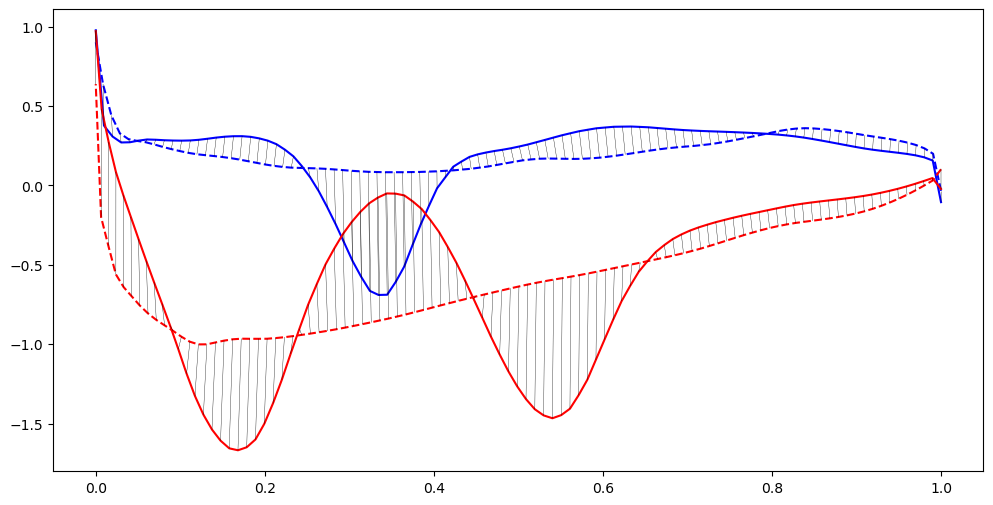

In [97]:
# Create geometric distances

i1 = 34
i2 = 61

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(geom_array[i1,0,:,0], field_array[i1,0,:,0], 'b')
ax.plot(geom_array[i2,0,:,0], field_array[i2,0,:,0], linestyle='--', c='b')


ax.plot(geom_array[i1,1,:,0], field_array[i1,1,:,0], 'r')
ax.plot(geom_array[i2,1,:,0], field_array[i2,1,:,0], linestyle='--', c='r')


for i in range(ns):
    ax.plot([geom_array[i1,0,i,0], geom_array[i2,0,i,0]], [field_array[i1,0,i,0], field_array[i2,0,i,0]], c='k', linewidth=.25)
    ax.plot([geom_array[i1,1,i,0], geom_array[i2,1,i,0]], [field_array[i1,1,i,0], field_array[i2,1,i,0]], c='k', linewidth=.25)

#ax.set_aspect('equal')

plt.show()

In [80]:
# Get the indices that would sort the flattened array
arr = distance_field[:,:,1]
flat_indices = np.argsort(arr.ravel())

# Convert the flat indices to 2D indices
sorted_indices = np.unravel_index(flat_indices, arr.shape)

# Combine the indices into a list of tuples
results = list(zip(*sorted_indices))

for i, result in enumerate(results):
        print(result, arr[result])

(25, 39) 0.006840182787529984
(25, 61) 0.007729357718111351
(37, 57) 0.008582785931558597
(39, 61) 0.008666439248095237
(2, 57) 0.008930673695171271
(2, 61) 0.009071188154390309
(2, 43) 0.009856893869478132
(25, 37) 0.00995007651525115
(37, 61) 0.00996181117407486
(39, 43) 0.010093833321241141
(25, 43) 0.010121092915459432
(53, 69) 0.010361215668295305
(37, 39) 0.010661032437018353
(37, 43) 0.010833653566059458
(2, 25) 0.011090885819988468
(27, 61) 0.01128351587495009
(39, 57) 0.011358227826647374
(2, 27) 0.011429130936680177
(57, 61) 0.011491945993816852
(27, 43) 0.011686762962832439
(4, 18) 0.011693375784414019
(25, 57) 0.011768711585805898
(2, 39) 0.011844962964665305
(52, 70) 0.011918538509229283
(55, 57) 0.011954740618735114
(4, 57) 0.011978393957008003
(51, 55) 0.012128193274085505
(18, 22) 0.012201961372175515
(1, 19) 0.012271942197831674
(4, 45) 0.012455241516362778
(6, 51) 0.01257555975341954
(43, 57) 0.012582717532671577
(22, 45) 0.012616106560382173
(27, 57) 0.01275788307461

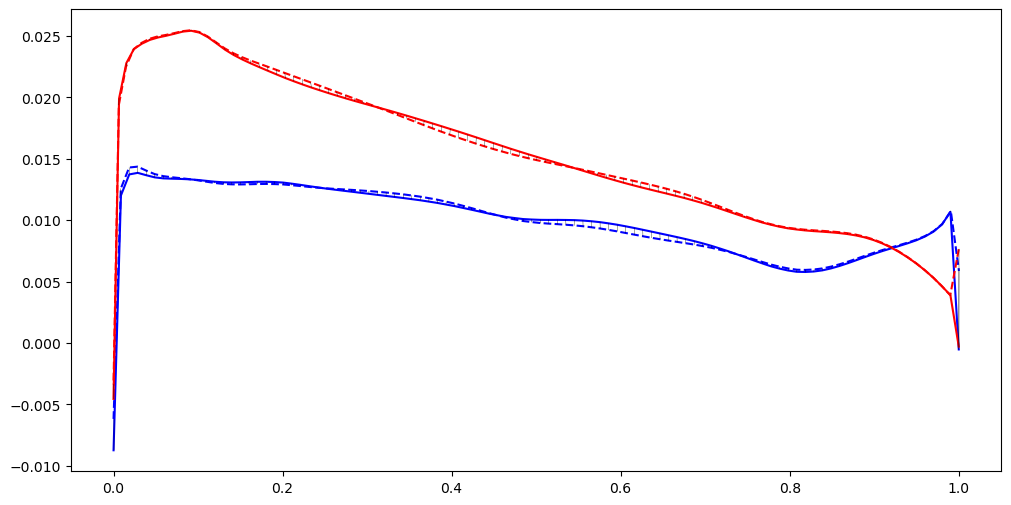

In [81]:
# Create geometric distances

i1 = 22
i2 = 61

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(geom_array[i1,0,:,0], field_array[i1,0,:,1], 'b')
ax.plot(geom_array[i2,0,:,0], field_array[i2,0,:,1], linestyle='--', c='b')


ax.plot(geom_array[i1,1,:,0], field_array[i1,1,:,1], 'r')
ax.plot(geom_array[i2,1,:,0], field_array[i2,1,:,1], linestyle='--', c='r')


for i in range(ns):
    ax.plot([geom_array[i1,0,i,0], geom_array[i2,0,i,0]], [field_array[i1,0,i,1], field_array[i2,0,i,1]], c='k', linewidth=.25)
    ax.plot([geom_array[i1,1,i,0], geom_array[i2,1,i,0]], [field_array[i1,1,i,1], field_array[i2,1,i,1]], c='k', linewidth=.25)

#ax.set_aspect('equal')

plt.show()

In [7]:
itarget = 0

distance_geometry = np.ones((ndata, ndata))*1e6
distance_field = np.ones((ndata, ndata))*1e6

for itarget in range(ndata):
    xytarget = geom_array[itarget,:,:,:]
    vtarget = field_array[itarget,:,:]
    
    for i in range(itarget+1,ndata):
        if i==itarget:
            distance_geometry[itarget, i] = 1e6
            distance_field[itarget, i] = 1e6
        else:
            xy = geom_array[i,:,:,:]
            v  = field_array[i,:,:]
    
            distance_geometry[itarget, i] = np.sum(np.sqrt(np.sum((xy - xytarget)**2, axis=1)))
            distance_field[itarget, i] = np.sum(np.sqrt(np.sum((v-vtarget)**2, axis=1)))

        if distance_geometry[itarget, i] < 5e-2:
            distance_geometry[itarget, i] = 1e6
            distance_field[itarget, i] = 1e6

print(distance_geometry.min())

0.050094470460303235


In [8]:
matrix = distance_field
indices_1d = np.argpartition(matrix, 3, axis=None)[:3]
indices_2d_field = np.unravel_index(indices_1d, matrix.shape)
least_three_field = matrix[indices_2d_field]

print('least three values : ', least_three_field)
print('indices : ', *zip(*indices_2d_field) )

least three values :  [0.72723159 0.78125221 0.79566352]
indices :  (10, 51) (10, 37) (2, 10)


In [9]:
matrix = distance_geometry
indices_1d = np.argpartition(matrix, 3, axis=None)[:3]
indices_2d_geometry = np.unravel_index(indices_1d, matrix.shape)
least_three_geometry = matrix[indices_2d_geometry]

print('least three values : ', least_three_geometry)
print('indices : ', *zip(*indices_2d_geometry) )

least three values :  [0.05044354 0.05027009 0.05009447]
indices :  (47, 53) (19, 30) (15, 43)


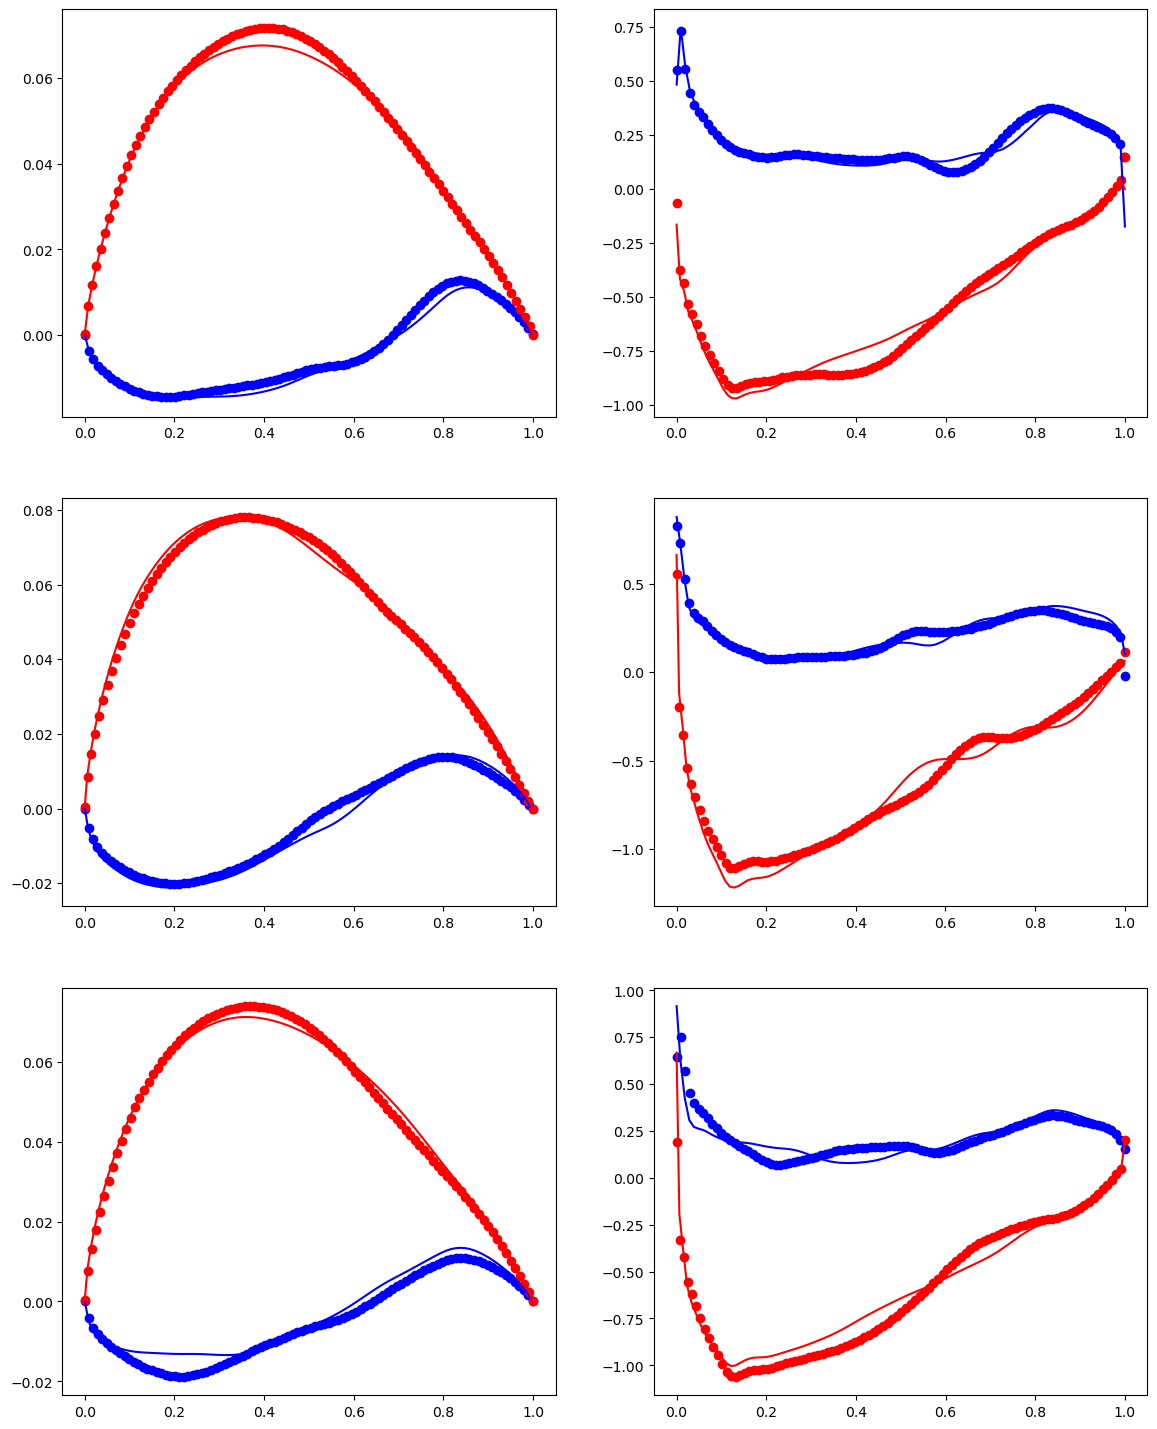

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,18))

for i in range(3):
    ix1, ix2 = indices_2d_geometry[0][i], indices_2d_geometry[1][i]
    iv1, iv2 = indices_2d_field[0][i], indices_2d_field[1][i]

    xytarget = geom_array[ix1,:,:,:]
    vtarget  = field_array[ix1,:,:]
    
    xy = geom_array[ix2,:,:,:]
    v  = field_array[ix2,:,:]

    axs[i,0].scatter(xytarget[0,:,0], xytarget[0,:,1], c='b')
    axs[i,0].plot(xy[0,:,0], xy[0,:,1], c='b')

    axs[i,0].scatter(xytarget[1,:,0], xytarget[1,:,1], c='r')
    axs[i,0].plot(xy[1,:,0], xy[1,:,1], c='r')

    axs[i,1].scatter(xytarget[0,:,0], vtarget[0,:], c='b')
    axs[i,1].plot(xy[0,:,0], v[0,:], c='b')

    axs[i,1].scatter(xytarget[1,:,0], vtarget[1,:], c='r')
    axs[i,1].plot(xy[1,:,0], v[1,:], c='r')

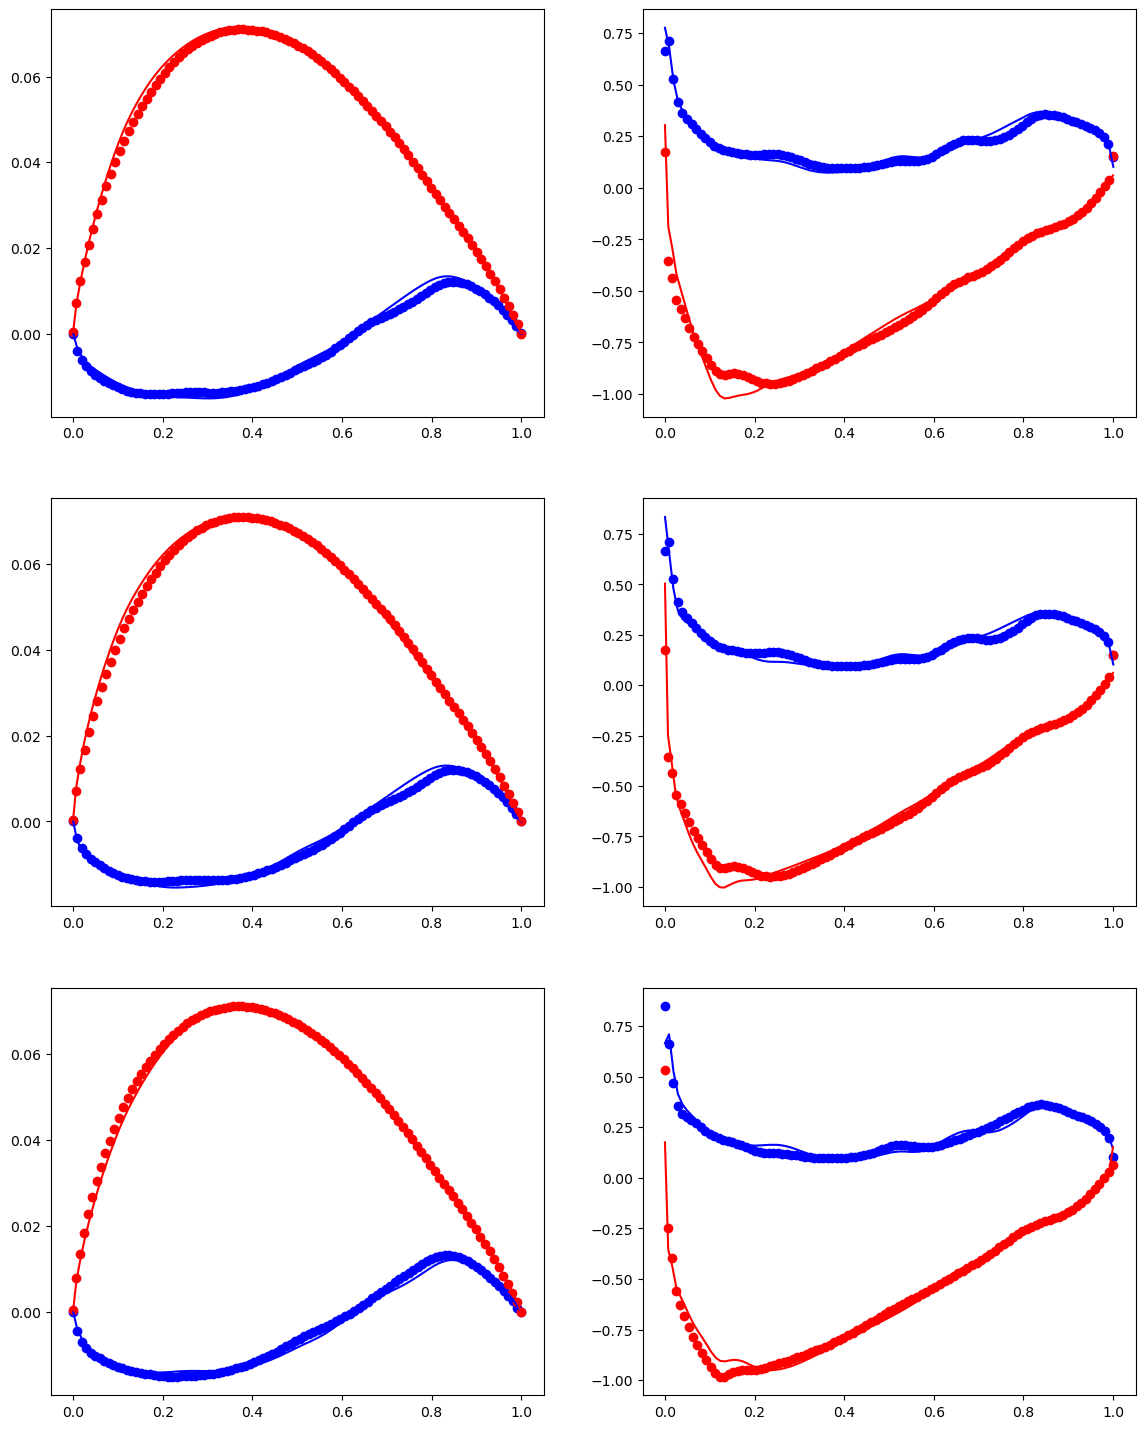

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,18))

for i in range(3):
    ix1, ix2 = indices_2d_geometry[0][i], indices_2d_geometry[1][i]
    iv1, iv2 = indices_2d_field[0][i], indices_2d_field[1][i]

    xytarget = geom_array[iv1,:,:,:]
    vtarget  = field_array[iv1,:,:]
    
    xy = geom_array[iv2,:,:,:]
    v  = field_array[iv2,:,:]

    axs[i,0].scatter(xytarget[0,:,0], xytarget[0,:,1], c='b')
    axs[i,0].plot(xy[0,:,0], xy[0,:,1], c='b')

    axs[i,0].scatter(xytarget[1,:,0], xytarget[1,:,1], c='r')
    axs[i,0].plot(xy[1,:,0], xy[1,:,1], c='r')

    axs[i,1].scatter(xytarget[0,:,0], vtarget[0,:], c='b')
    axs[i,1].plot(xy[0,:,0], v[0,:], c='b')

    axs[i,1].scatter(xytarget[1,:,0], vtarget[1,:], c='r')
    axs[i,1].plot(xy[1,:,0], v[1,:], c='r')